BraTS Challenge Demo-Notebook

In [15]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from dataset_utils import split_cube
from visualization_utils import plot_confusion_matrix, plot_loss, animate_cube, get_positives_negatives_from_cm
from data_loading import get_train_test_iters
torch.manual_seed(42)
from Architectures.unet_3d import UNet3D
from Architectures.unet_3d_context import UNet3D_Mini
from Architectures.unet_2d import UNet2D
from train import train_model
from custom_losses import DiceLoss

Data Loading

In [2]:
batch_size = 1
dataset_path = os.path.join('..', 'Task01_BrainTumour', 'cropped')
train_iter, test_iter = get_train_test_iters(dataset_path, batch_size=batch_size, shuffle=True, num_workers=0)

..\Task01_BrainTumour\cropped\imagesTr
..\Task01_BrainTumour\cropped\labelsTr
..\Task01_BrainTumour\cropped\imagesTs
..\Task01_BrainTumour\cropped\labelsTs


In [5]:
batch = split_cube(train_iter.next(), add_context=False)
batch['image'].shape

Tue Aug 23 12:45:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.23       Driver Version: 511.23       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   57C    P8    13W /  N/A |    148MiB /  6144MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Create the model

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

cuda
NVIDIA GeForce RTX 3060 Laptop GPU


Training Loop

In [4]:
# hyperparameters
train_3d = True
add_context = True
compute_test_loss = True
epochs = 1
learning_rate = 0.1

# init model
if train_3d:
    if add_context:
        model = UNet3D_Mini(num_modalities=4, num_classes=4).to(device)
    else:
        model = UNet3D(num_modalities=4, num_classes=4).to(device)
else:
    model = UNet2D().to(device)

# init optimizer and loss_fn
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = DiceLoss()

In [6]:
# Training
print(f'training {model.__class__.__name__}:')
train_losses, test_losses = train_model(model, optim, loss_fn, epochs, device, dataset_path, batch_size, train_3d, add_context, compute_test_loss)

training UNet3D:
..\Task01_BrainTumour\cropped\imagesTr
..\Task01_BrainTumour\cropped\labelsTr
..\Task01_BrainTumour\cropped\imagesTs
..\Task01_BrainTumour\cropped\labelsTs
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
epoch 0: epoch_train_loss=0.741, epoch_test_loss=0.740


Plot losses

Loss curve using DiceLoss():


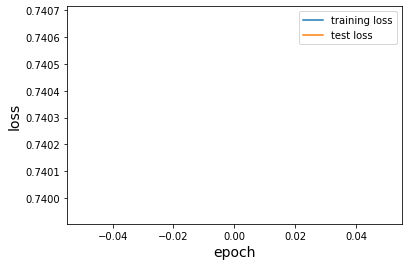

In [7]:
print(f'Loss curve using {loss_fn}:')
plot_loss(train_losses, test_losses)

Load inference model

In [5]:
weights_path = os.path.join('..','Weights')
weights_filename = os.listdir(weights_path)[len(os.listdir(weights_path))-1]
if train_3d:
    if add_context:
        inference_model = UNet3D_Mini(num_modalities=4, num_classes=4).to(device)
    else:
        inference_model = UNet3D(num_modalities=4, num_classes=4).to(device)
else:
    inference_model = UNet2D().to(device)
#inference_model.load_state_dict(torch.load(os.path.join(weights_path, weights_filename)))
inference_model.eval();

Predict

In [7]:
batch = train_iter.next()
%matplotlib notebook

ani = animate_cube(inference_model, batch, add_context, device, train_3d)
plt.show()
del batch
!nvidia-smi

<IPython.core.display.Javascript object>

Tue Aug 23 12:44:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.23       Driver Version: 511.23       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   59C    P5    30W /  N/A |   1852MiB /  6144MiB |     19%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Confusion Matrix

In [7]:
import gc
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())

43445248
Tue Aug 23 13:43:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.23       Driver Version: 511.23       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P8    12W /  N/A |    294MiB /  6144MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               

..\Task01_BrainTumour\cropped\imagesTr
..\Task01_BrainTumour\cropped\labelsTr
..\Task01_BrainTumour\cropped\imagesTs
..\Task01_BrainTumour\cropped\labelsTs
0
1
2
3
4
5
6
7


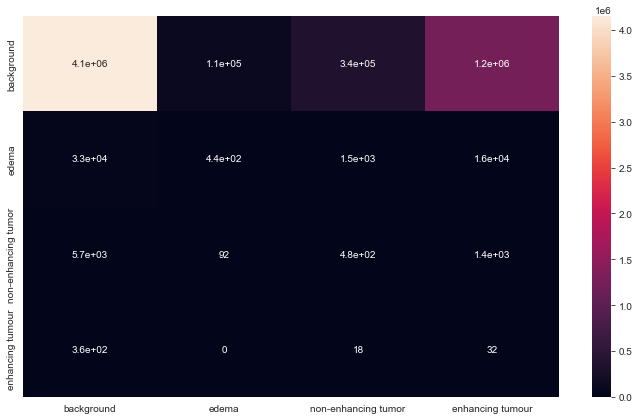

In [7]:
train_iter, test_iter = get_train_test_iters(os.path.join('..', 'Task01_BrainTumour', 'cropped'), batch_size=batch_size, shuffle=False, num_workers=0)

cf_matrix_visu, cf_matrix = plot_confusion_matrix(test_iter, model, train_3d, add_context, device=device)
cf_matrix_visu.show()

In [23]:
get_positives_negatives_from_cm(cf_matrix.to_numpy())

background:
tp: 4149047
fp: 1690052
tn: 19771
fn: 39370
precision: 0.711
recall: 0.991
accuracy: 0.703
f1_score: 0.828

edema:
tp: 441
fp: 50562
tn: 5733835
fn: 113402
precision: 0.009
recall: 0.004
accuracy: 0.000
f1_score: 0.005

non-enhancing tumor:
tp: 479
fp: 7251
tn: 5547856
fn: 342654
precision: 0.062
recall: 0.001
accuracy: 0.000
f1_score: 0.003

enhancing tumour:
tp: 32
fp: 376
tn: 4645017
fn: 1252815
precision: 0.078
recall: 0.000
accuracy: 0.000
f1_score: 0.000

